<img src="./img/sktime-logo-text-horizontal.jpg" alt="sktime logo" style="width: 50%; max-width: 600px;">  <img src="./img/University_of_Waterloo_seal.svg.png" alt="UW Seal" style="width: 25%; max-width: 150px;"> 

# Type 1 Diabetes - Meal Identification Change Point Benchmark

## use case challenge!

1. background on type 1 Diabetes (T1D) and meal logging
2. meal detection task = semi-supervised change point detection
   - Full data set with example notebook: [https://github.com/Blood-Glucose-Control/t1d-change-point-detection-benchmark](https://github.com/Blood-Glucose-Control/t1d-change-point-detection-benchmark)
3. **semi-supervised change point detection data set**, generated by open source FDA approved T1D simulator
4. contribution challenge!
   * implement semi-supervised detectors
   * develop effective algorithm for meal detection!

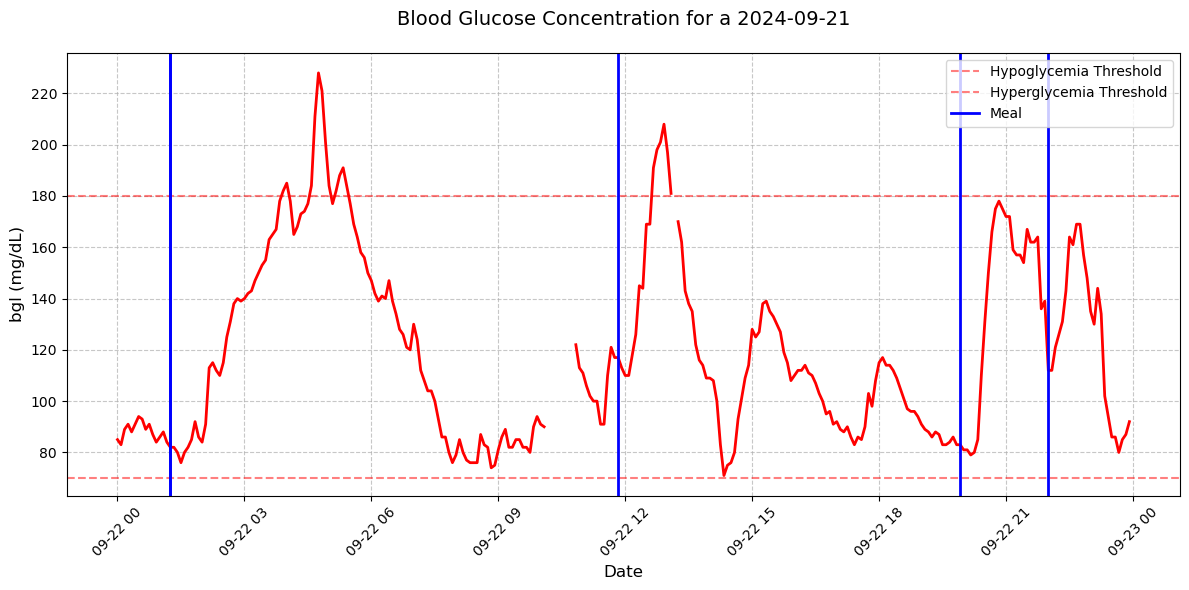

## 1. Challenge Background

### Prandial Blood Glucose Dynamics Goals in Type 1 Diabetes 
Type 1 Diabetes (T1D) = medical condition

* pancreas produces little to no insulin (=hormone regulating blood glucose)
* Managing T1D is challenging! Insulin injections & meal uptake planning

** Main goal: keep blood glucose in healthy range!**

1. Range (70mg/dL - 180 mg/dL or 3.9mmol/L - 10.0 mmol/L blood glucose levels (BGL)),
2. Too low: hypoglycemia risk, deadly! (when BGL < 3.9mmol/L)
3. Minimizing [diabetes distress](https://www.diabetes.ca/about-diabetes-(3)/impact-stories/distressed-by-diabetes) or "diabetes burnout".
   
**Requires meticulous tracking of:**
- meals, carbohydrates consumed 
- amount of insulin taken before the meal
- timing of insulin before the meal

- See [InsuLearn](http://ddi.ucsd.edu/insulearn/)

### Challenge Task

**Automatic Identification of Meals** from blood glucose curves

**Real-world training data is incomplete! - Users do not record all meals.**

Using [continuous glucose monitors (CGM)](https://www.niddk.nih.gov/health-information/diabetes/overview/managing-diabetes/continuous-glucose-monitoring), can we automatically identify meals from blood glucose levels? 

"Higher order goal": What tools can make the logging of meals more streamlined and automated? 

**Benefits for diabetics (and doctors):** 

- more reliable tracker data, reduced cognitive burden, reduced health risk
- improved datasets for researchers for downstream tasks like probabilistic forecasting (hypoglycemia etc)


## 2. Data Overview

### Data Generation
data generated from FDA-approved [UVA/PADOVA Type 1 Diabetes Simulator](https://journals.sagepub.com/doi/10.1177/1932296813514502).

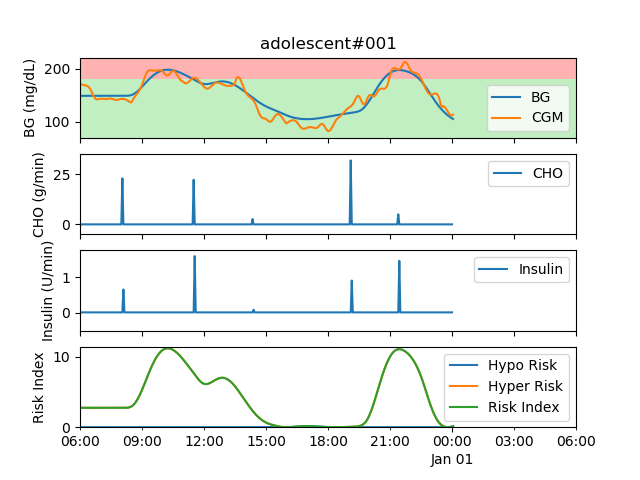

[Image Source](https://github.com/jxx123/simglucose/blob/master/screenshots/animate.png)

Simulation settings:

- 30 patients (10 children, 10 adolecents, 10 adults)
- 3 cgms (GaurdianRT, Navigator, Dexcom)
- 2 Insulin Pumps (Insulet, Cozmo)

Total: 180 csv files, 90 days per csv, varying number of change points in each csv.

More custom cgms and pump settings in advanced versions (future work).

### Data Obfuscation

To simulate "not all meals are recorded" by patients

- For each patient we randomly sample a **meal logging obfuscation scheme**:
  1. All meals
  2. Multiple meals per day (1-2 largest meals)
  3. Once per day (largest meal)
  4. A few times per week
  5. Never
   
- For each patient we randomly sample from a **meal time logging habit distribution**:
  1. Temporally right skewed -> forgetful loggers
  2. Temporally left skewed -> hasty loggers
  3. Normal Distribution 
  4. Unchanged 
  
For recorded meal, adjust time by logging habit distribution.

### Data set Description

- **date:** time stamp, sampled at 5-minute intervals
- **bgl_real:** the 'real' simulated blood glucose level inside the blood stream of the simulated t1d patient
- **bgl_cgm:** simulated blood glucose level as read from the continuous glucose monitor sensor, reflecting real world cgm inaccuracies and noise.
- **meal_start_true_change_point:** ground truth time of meal = ground truth change point
  - True change points:  `df[df['meal_start_true_change_point'] == 'ANNOUNCE_MEAL'].index`.
- **meal_start_obfuscation_change_point:** observed meal log, after obfuscation
  - True change points:  `df[df['meal_start_obfuscation_change_point'] == 'ANNOUNCE_MEAL'].index`.
- **food_g:** food that the T1D has consumed, for information, *not to be used in modelling*. 


#### Data Example (one change point)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='bgl_cgm'>)

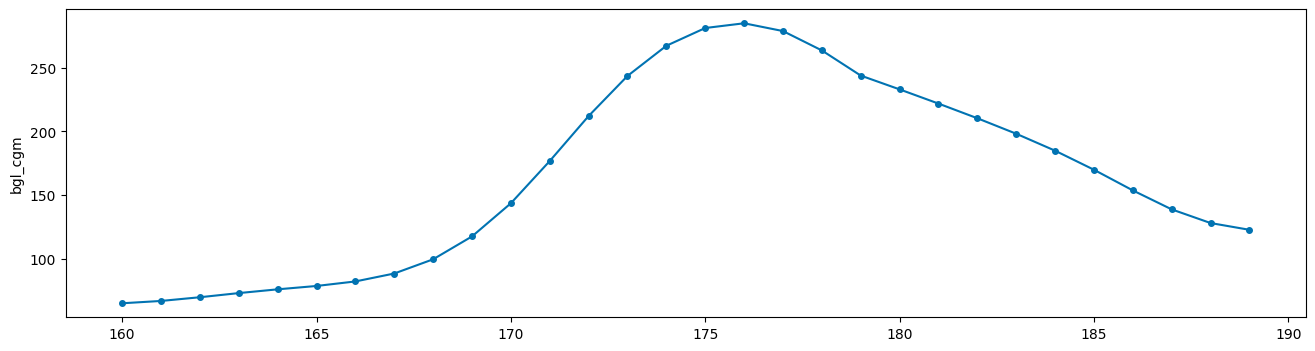

In [1]:
import pandas as pd
import os
from sktime.utils.plotting import plot_series

current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'example_data/chi001_GuardianRT_Cozmo_2024-02-01_2024-04-30.csv')
df = pd.read_csv(file_path)
plot_series(df['bgl_cgm'][160:190])

In [2]:
df[160:185]

,date,bgl_real,bgl_cgm,meal_start_change_point,food_g
160,2024-02-01 17:20:00,64.443987,65.140843,NaN,NaN
161,2024-02-01 17:25:00,64.477998,66.972215,NaN,NaN
162,2024-02-01 17:30:00,64.755972,69.879939,NaN,NaN
163,2024-02-01 17:35:00,65.343380,73.133296,NaN,NaN
164,2024-02-01 17:40:00,66.349353,76.088288,ANNOUNCE_MEAL,18.6
165,2024-02-01 17:45:00,67.947452,78.720801,NaN,NaN
166,2024-02-01 17:50:00,70.364130,82.276919,NaN,NaN
167,2024-02-01 17:55:00,74.483260,88.502362,NaN,NaN
168,2024-02-01 18:00:00,82.631609,99.655805,NaN,NaN
169,2024-02-01 18:05:00,97.774643,117.602011,NaN,NaN


In [3]:
import numpy as np

np.random.uniform(0, 1, 10)
[0,0.05, 0.2, 0.3, 0.5, 1.0]

[0, 0.05, 0.2, 0.3, 0.5, 1.0]

### All change points (1 patient - 90 days):
There are 337 meals for this simulation:

In [4]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)
df[df['meal_start_change_point'] == 'ANNOUNCE_MEAL'].index

DatetimeIndex(['2024-02-01 06:25:00', '2024-02-01 13:40:00',
               '2024-02-01 17:40:00', '2024-02-02 06:45:00',
               '2024-02-02 11:05:00', '2024-02-02 18:30:00',
               '2024-02-03 06:30:00', '2024-02-03 09:35:00',
               '2024-02-03 11:50:00', '2024-02-03 17:45:00',
               ...
               '2024-04-28 17:55:00', '2024-04-28 21:55:00',
               '2024-04-29 08:00:00', '2024-04-29 10:40:00',
               '2024-04-29 17:30:00', '2024-04-30 07:20:00',
               '2024-04-30 09:40:00', '2024-04-30 13:30:00',
               '2024-04-30 14:55:00', '2024-04-30 17:35:00'],
              dtype='datetime64[ns]', name='date', length=337, freq=None)

In [5]:
df_single_day = df.loc['2024-02-02']
df_single_day

,bgl_real,bgl_cgm,meal_start_change_point,food_g
date,,,,
2024-02-02 00:00:00,74.897267,66.163252,NaN,NaN
2024-02-02 00:05:00,73.822090,64.906745,NaN,NaN
2024-02-02 00:10:00,72.888574,66.715359,NaN,NaN
2024-02-02 00:15:00,72.088528,70.364263,NaN,NaN
2024-02-02 00:20:00,71.413756,74.628539,NaN,NaN
...,...,...,...,...
2024-02-02 23:35:00,110.111823,117.959158,NaN,NaN
2024-02-02 23:40:00,108.297313,119.498724,NaN,NaN
2024-02-02 23:45:00,106.015350,118.443194,NaN,NaN


In [6]:
cpts = df_single_day[df_single_day['meal_start_change_point'] == 'ANNOUNCE_MEAL'].index
cpts

DatetimeIndex(['2024-02-02 06:45:00', '2024-02-02 11:05:00',
               '2024-02-02 18:30:00'],
              dtype='datetime64[ns]', name='date', freq=None)

### Change Dectection Using MovingWindow and CUSUM

In [7]:
from skchange.change_detectors import MovingWindow
from skchange.change_scores import CUSUM
import plotly.express as px

from utils import plot_multivariate_time_series
from utils import plot_changepoint_illustration
from utils import add_changepoint_vlines
from utils import add_segmentation_vrects

plot_df = (
    df_single_day[['bgl_cgm', 'bgl_real']].stack()
    .reset_index()
    .rename({"level_0": "date", "level_1": "variable", 0: "value"}, axis=1)
)
fig = px.line(plot_df, x="date", y="value", facet_row="variable", title="BGL CGM and BGL Real")
fig.update_layout(showlegend=False, xaxis_title=None)


In [8]:
change_detector = MovingWindow(
    change_score=CUSUM(),
    bandwidth=36,  # The number of samples on each side of a split point.
)
change_detector.fit(df_single_day['bgl_cgm'])
window_scores = change_detector.transform_scores(df_single_day['bgl_cgm'])
px.line(window_scores).update_layout(
    yaxis_title="CUSUM change score",
    showlegend=False,
)


In [9]:
changepoints = change_detector.predict(df_single_day['bgl_cgm'])
df_single_day['bgl_cgm'].iloc[changepoints["ilocs"]].index

DatetimeIndex(['2024-02-02 05:35:00', '2024-02-02 08:40:00',
               '2024-02-02 11:30:00', '2024-02-02 13:40:00',
               '2024-02-02 19:00:00', '2024-02-02 21:00:00'],
              dtype='datetime64[ns]', name='date', freq=None)

In [10]:
changepoints["time_locs"] = df_single_day['bgl_cgm'].iloc[changepoints["ilocs"]].index
meal_changepoints = add_changepoint_vlines(fig, changepoints, "time_locs")
meal_changepoints.update_layout(showlegend=False, xaxis_title=None).show()

In [11]:
segment_labels = change_detector.transform(df_single_day['bgl_cgm'])
segments = (
    segment_labels
    .groupby("labels")
    .apply(lambda x: pd.Interval(x.index[0], x.index[-1] + pd.Timedelta(seconds=1), closed="left"), include_groups=False)
).to_frame()
segments.columns = ["time_locs"]
segments["labels"] = segment_labels["labels"].unique()
segments

add_segmentation_vrects(fig, segments, locs_col="time_locs").update_layout(
    showlegend=False, xaxis_title=None
)


Note that `bgl_cgm` should be used, not `bgl_real`. `bgl_cgm` adds realistic noise the simulated `bgl_real` data.

Not bad! But there is definitely room for improvement! And not all time series will be as simple as this one.



### Histogram of Meal Times
Meal times for many patients are highly irregular, even for habitual individuals (like below) the distributions have high variance, we cannot rely completely on prior historical data to predict when meals occur:

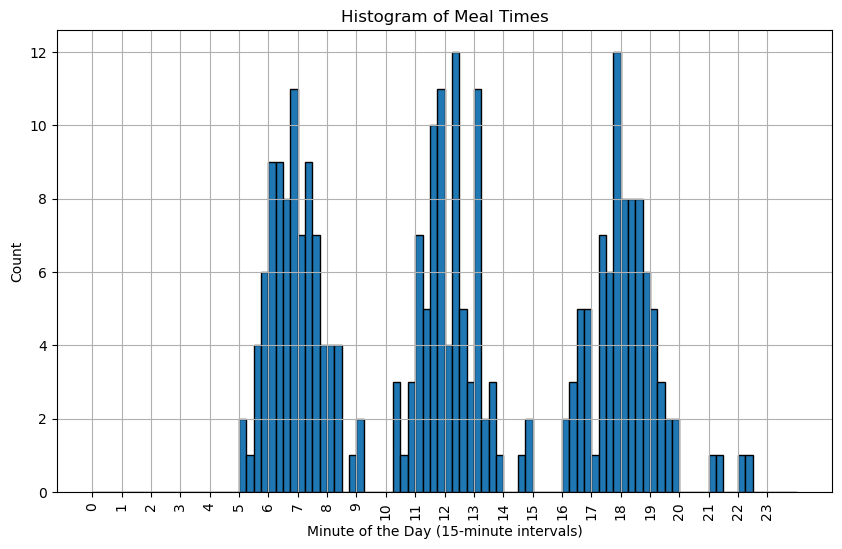





### Evaluation Metrics

We are in the process of adding the following evaluation metrics to the detector module of `sktime`

- RAND INDEX: the average similarity between the predicted breakpoint set and the ground truth. [Source: (C. Truong et al. 2018, Section 3.2.3)](https://www.sciencedirect.com/science/article/pii/S0165168419303494?via%3Dihub)

- F1-Score (change point). [Source: (C. Truong et al. 2018, Section 3.2.4)](https://www.sciencedirect.com/science/article/pii/S0165168419303494?via%3Dihub)
  -  **Precision** is the proportion of predicted change points that are true change points.
  -  **Recall** is the proportion of true change points that are well predicted.
  -  A breakpoint is considered detected up to a user-defined margin of error $M > 0$; 
  -  true positives $T_p$ are true change points for which there is an estimated one at less than $M$ samples.

## Summary

Data is generated using a python implementation of an FDA approved T1D simulator (MIT license):

> Jinyu Xie. Simglucose v0.2.1 (2018) [Online]. Available: https://github.com/jxx123/simglucose. Accessed on: Nov-27-2024.

Python implementation is based on:

> [Man CD, Micheletto F, Lv D, Breton M, Kovatchev B, Cobelli C. The UVA/PADOVA Type 1 Diabetes Simulator: New Features. Journal of Diabetes Science and Technology. 2014;8(1):26-34. doi:10.1177/1932296813514502](https://journals.sagepub.com/doi/10.1177/1932296813514502)

The completed benchmark will: 

- Modify the simulated data to be based off of real world semi-supervised unlabelled data rates. 
   - Patients meal logging habits will vary into logging multiple meals per day, once per day, every other day, a few times per week, to never. 
   - Ideally we can learn enough information from the frequent loggers to be able to identify meals for all types of users. 

### How to Contribute:
- Develop new semi-supervised detection estimators
  * [adding estimators guide](https://www.sktime.net/en/latest/developer_guide/add_estimators.html)
  * [API reference detectors](https://www.sktime.net/en/stable/api_reference/detection.html)
- Develop new semi-supervised change point detection metrics
  * [Join Blood Glucose Control Project](https://github.com/RobotPsychologist/bg_control)

### Future Work
- Additional benchmarking challenges to evaluate transfer learning settings, 
   1. adult -> child, 
   2. manufacturer1_sensor_type -> manufacturer2_sensor_type, 
   3. manufacturer1_pump -> manufacturer2_pump
- Create automatic benchmarking evaluator with the sktime api


### Expected Release

Alpha version v0.0.1 ready by the end of the week.

Expect the release of v1.0.0 of the benchmark in early 2025!


More information available at:
- Create a PR with a great algorithm here: [Blood Glucose Control Project](https://github.com/RobotPsychologist/bg_control)
- Where the benchmark will be hosted -> [t1d-change-point-detection-benchmark](https://github.com/Blood-Glucose-Control/t1d-change-point-detection-benchmark)
- Blood Glucose Control Team's current repo -> [https://github.com/RobotPsychologist/bg_control](https://github.com/RobotPsychologist/bg_control)